# Perfect Foresight CRRA Model - Approximation

In [1]:
# Initial notebook set up

%matplotlib inline
import matplotlib.pyplot as plt
# The first step is to be able to bring things in from different directories
import sys 
import os

sys.path.insert(0, os.path.abspath('../lib'))

import numpy as np
import HARK 
from time import clock
from copy import deepcopy
mystr = lambda number : "{:.4f}".format(number)
from HARK.utilities import plotFuncs

# These last two will make our charts look nice
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Dark2')

[PerfectForesightCRRA](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/Consumption/PerfForesightCRRA) derives a number of results as approximations; for instance, the exact formula for the consumption function is derived as $$c_t = \left(\frac{R - (R\beta)^{1/\rho}}{R}\right)o_t$$
and approximated by $$c_t \approx (r-\rho^{-1}(r-\theta))o_t$$.

Your task is to make a series of plots that show how the quality of the approximation deteriorates as you change various model parameters. The notebook aims to make this easier by showing that under the baseline parameter values, the percentage amount of the error is pretty much constant across different values of market resources, so you can assume that is generically true.

To get you started, we show how to conduct the exercise under particularly simple parameterization (the Deaton/Friedman model where $R = \frac{1}{\beta}$, in which the only relevant parameter is the interest rate).

Your specific assignment is:

1. Starting with the default parameterization of the model, show how the approximation quality changes with values of other parameters
1. Explain, mathematically, why you get the patterns you do for how the solutions deteriorate as you change the parameter values

Hints: 

1. [MathFactsList](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/MathFacts/MathFactsList.pdf) describes the conditions under which the approximations will be good; you want to find conditions under which the approximations get bad
2. An interesting question is the extent to which the size of approximation errors is related to the degree of impatience according to alternative metrics

In [2]:
# Set up a HARK Perfect Foresight Consumer called PFagent

from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType # Import the consumer type

# Now we need to give our consumer parameter values that allow us to solve the consumer's problem

# We begin by importing a module that can be invoked to cough up default parameter values
import HARK.ConsumptionSaving.ConsumerParameters as Params

# Invoke it to create a dictionary called Paramod (Params that we will modify)
Paramod = deepcopy(Params.init_perfect_foresight) # deepcopy prevents later overwriting

# Extract the parameters from the dictionary to make them easy to reference
CRRA       = Paramod['CRRA']                # Coefficient of relative risk aversion
Rfree      = Paramod['Rfree']               # Interest factor on assets
DiscFac    = Paramod['DiscFac']             # Intertemporal discount factor
PermGroFac = Paramod['PermGroFac']          # Permanent income growth factor
LivPrb     = Paramod['LivPrb']     = [1.0]  # Survival probability of 100 percent
cycles     = Paramod['cycles']     = 0      # This says that it is an infinite horizon model

In [3]:
# Now let's pass our dictionary to our consumer class to create an instance 
PFagent = PerfForesightConsumerType(**Paramod) # Any parameters we did not modify get their default values

# Solve the agent's problem
PFagent.solve()

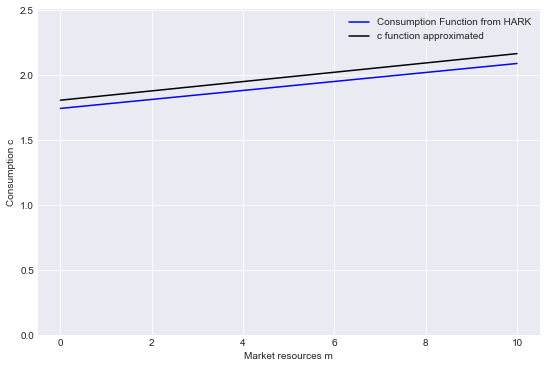

In [4]:
# Plot the consumption function approximation versus the "true" consumption function

# Set out some range of market resources that we want to plot consumption for
mMin = 0 
mMax = 10
numPoints = 100
m_range = np.linspace(mMin, mMax, numPoints) # This creates an array of points in the given range

wealthHmn = PFagent.solution[0].hNrm # normalized human wealth is constructed when we .solve()
wealthMkt = m_range                  # bank balances plus current income
wealthTot = wealthHmn+wealthMkt      # Total wealth is the sum of human and market 

# Feed our range of market resources into our consumption function in order to get consumption at each point
# (Remember, after doing .solve(), the consumption function is stored as PFagent.solution[0].cFunc)
cHARK = PFagent.solution[0].cFunc(m_range) # Because the input m_range is an array, the output cHARK is too
cMax  = cHARK[-1]*1.2 # The last point will be the largest; add 20 percent for visual appeal

# Use matplotlib package (imported in first cell) to plot the consumption function
plt.figure(figsize=(9,6)) # set the figure size
plt.plot(m_range, cHARK, 'b', label='Consumption Function from HARK') # m on the x axis vs c on the y axis
# 'b' is for blue
plt.xlabel('Market resources m') # x axis label
plt.ylabel('Consumption c') # y axis label
plt.ylim(0,cMax)

# The plot is named plt and it hangs around like a variable 
# but is not displayed until you do a plt.show()

# Construct the approximate consumption function
# Also, recall that in the "true" consumption function what matters is total wealth, 
# not just market resources so we need to add in human wealth

# Use the values of R, beta, and rho that we used above to construct rates 
rfree=Rfree-1
discRte=(1/DiscFac)-1 # See handout for why this is approximately the time preference rate
cApprox = wealthTot*(rfree - (1/CRRA)*(rfree-discRte)) 
plt.plot(m_range, cApprox, 'k', label='c function approximated') # Add true consumption function line
plt.legend() # show the legend

plt.show() # show the plot

The size of the error looks pretty stable, which we can show by calculating it in percentage terms

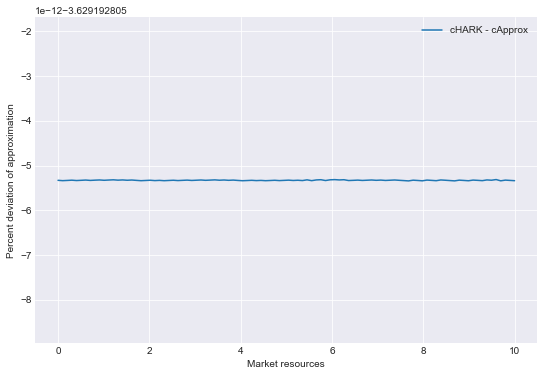

In [5]:
# Plot the deviations
approximationError = 100*(cHARK - cApprox)/cHARK
plt.figure(figsize=(9,6)) #set the figure size
plt.plot(m_range, approximationError, label='cHARK - cApprox')
plt.xlabel('Market resources') # x axis label
plt.ylabel('Percent deviation of approximation') # y axis label
plt.legend()
plt.show()

Now we want to calculate how the approximation quality depends on the interest factor.  We proceed as follows:
1. Create arrays of R values, such that the return patience factor is increasing as you descend through the array
2. Set up a for loop in which we will:
    1. Input the new value of $R$
    0. Solve the HARK model for the consumption function
    0. Calculate the approximate consumption function
    0. Save the average deviation between the two functions
3. Then we can plot average deviation against the $R$ factor

In [6]:
# Create array of Rfree values, and calculate the patience factor
howMany = 30
Rfree_min = Rfree
Rfree_max = Rfree**20
Rfree_array = np.linspace(Rfree_min, Rfree_max, howMany)

Pat_array  = (Rfree_array*DiscFac)**(1/CRRA)
PatR_array = Pat_array/Rfree_array

In [7]:
# Set the time preference factor to match the interest factor so that $(R \beta) = 1$

Paramod['DiscFac'] = 1/Rfree

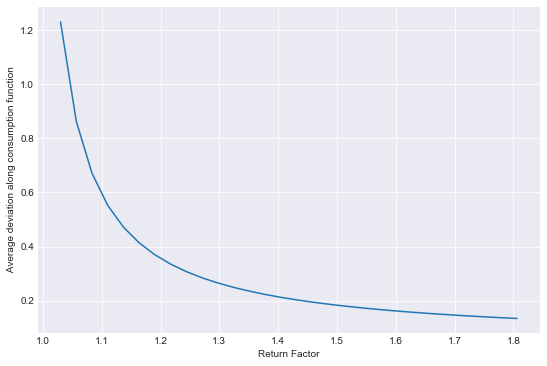

In [8]:
# Plot average deviation from true consumption function
PFagent = PerfForesightConsumerType(**Paramod) # construct a consumer with our previous parameters

plt.figure(figsize=(9,6)) #set the figure size
mean_dev = np.zeros(30)

for i in range(len(Rfree_array)):
    PFagent.Rfree = Rfree_array[i]
    
    # Now we just copy the lines of code from above that we want
    PFagent.solve()
    cHARK     = PFagent.solution[0].cFunc(m_range)
    wealthHmn = PFagent.solution[0].hNrm
    wealthTot = wealthHmn+m_range
    rfree=Rfree-1
    discRte=(1/DiscFac)-1 
    cApprox   = wealthTot*(rfree - (1/CRRA)*(rfree-discRte)) 
    deviation = np.mean(np.abs(cApprox/cHARK))
    mean_dev[i] = deviation
    
plt.plot(Rfree_array,mean_dev)
plt.xlabel('Return Factor') # x axis label
plt.ylabel(' Average deviation along consumption function') # y axis label
plt.show()

So, when the return factor gets to roughly 1.4, the error in the approximation is almost 80 percent.  It looks like the value for $R$ where the approximation almost exactly matches the truth is about 1.035.